# Setup and Get Data

##### Installations required

1. *labelme*
2. *tensorflow*
3. *opencv-python*
4. *matplotlib*
5. *albumentations*

After installing all these, remember to uninstall `opencv-python-headless`, as it causes conflicts.

### Collect Images using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [8]:
cap = cv2.VideoCapture(0)

for img_num in range(number_images):
    print('Collecting image {}'.format(img_num))
    ret, frame = cap.read()
    img_name = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(img_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Annotate Images with LabelMe

In [2]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\dasam\.labelmerc


# Review Dataset and Build Image Loading Function

#### Import TensorFlow and other libraries

In [3]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#### Limit GPU Memory Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load Image into TF Data Pipeline

In [7]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [8]:
images.as_numpy_iterator().next()

b'data\\images\\937fdbc2-521c-11ee-870e-58112281b583.jpg'

In [10]:
type(images)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [11]:
def load_image(x):
    # byte encoded image
    byte_img = tf.io.read_file(x)
    
    # decode the image
    img = tf.io.decode_jpeg(byte_img)
    
    return img

In [12]:
images = images.map(load_image)

In [13]:
images.as_numpy_iterator().next()

array([[[134, 127, 134],
        [138, 131, 138],
        [143, 136, 143],
        ...,
        [127, 131, 130],
        [127, 131, 130],
        [126, 130, 129]],

       [[141, 134, 141],
        [139, 132, 139],
        [141, 134, 141],
        ...,
        [126, 130, 129],
        [126, 130, 129],
        [126, 130, 129]],

       [[138, 133, 139],
        [136, 131, 137],
        [139, 134, 140],
        ...,
        [127, 131, 130],
        [127, 131, 130],
        [126, 130, 129]],

       ...,

       [[156, 156, 154],
        [156, 156, 154],
        [156, 156, 154],
        ...,
        [ 59,  56,  37],
        [ 56,  48,  29],
        [ 53,  42,  24]],

       [[156, 156, 154],
        [156, 156, 154],
        [155, 155, 153],
        ...,
        [ 47,  45,  33],
        [ 54,  45,  36],
        [ 51,  41,  32]],

       [[156, 156, 154],
        [156, 156, 154],
        [155, 155, 153],
        ...,
        [ 52,  49,  42],
        [ 53,  43,  41],
        [ 52,  41,  39]]

In [14]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### View Raw Images with Matplotlib

In [15]:
image_generator = images.batch(4).as_numpy_iterator()

In [18]:
plot_images = image_generator.next()

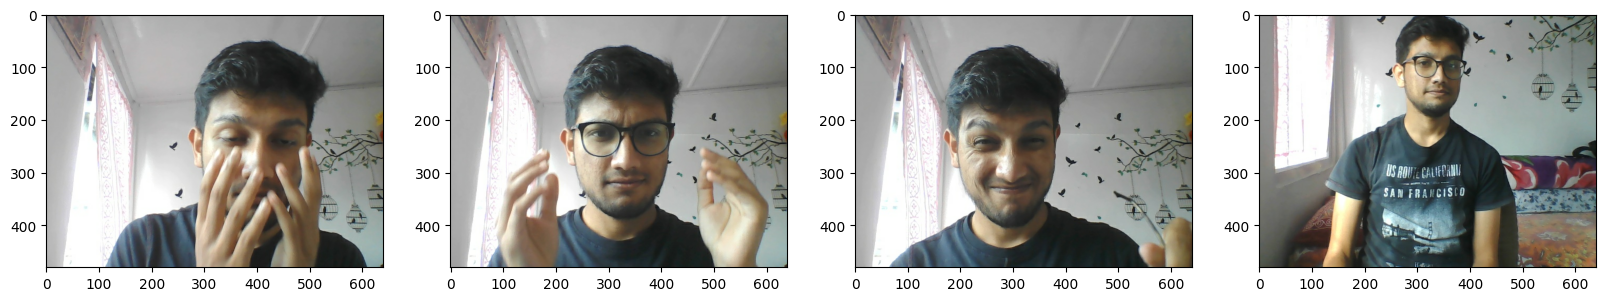

In [19]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))

for index, image in enumerate(plot_images):
    ax[index].imshow(image)

plt.show()

# Partition Unaugmented Data

##### Split data into train, test and validation

In [20]:
# Train
90 * 70/100

63.0

In [21]:
# Test and Validation
90 * 15/100
# 14 and 13 to test and val

13.5

#### Move the Matching Labels

In [ ]:
# for folder in ['train', 'test', 'val']:
#     for file in os.listdir(os.path.join('data', folder, 'images')):
        
#         file_name = file.split('.')[0] + '.json'
#         existing_filepath = os.path.join('data', 'labels', file_name)
        
#         if os.path.exists(existing_filepath):
#             new_filepath = os.path.join('data', folder, 'labels')
#             os.replace(existing_filepath, new_filepath)

# Apply Image Augmentation on Images and Labels using Albumentations

### Setup Albumentations Transform Pipeline

In [22]:
import albumentations as alb

In [23]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### Load a Test Image and Annotation with OpenCV and JSON

In [24]:
img = cv2.imread(os.path.join('data', 'train', 'images', '30b36f60-521d-11ee-9375-58112281b583.jpg'))

In [25]:
with open(os.path.join('data', 'train', 'labels', '30b36f60-521d-11ee-9375-58112281b583.json'), 'r') as f:
    label = json.load(f)

In [26]:
# coordinates of face
label['shapes'][0]['points']

[[173.24074074074076, 18.703703703703724],
 [438.98148148148147, 375.18518518518516]]

In [33]:
img

array([[[148, 139, 142],
        [146, 139, 142],
        [153, 151, 151],
        ...,
        [142, 143, 133],
        [141, 142, 132],
        [141, 142, 132]],

       [[149, 140, 143],
        [147, 140, 143],
        [153, 151, 151],
        ...,
        [142, 143, 133],
        [141, 142, 132],
        [141, 142, 132]],

       [[151, 142, 145],
        [149, 142, 145],
        [153, 148, 149],
        ...,
        [142, 143, 134],
        [142, 143, 134],
        [142, 143, 134]],

       ...,

       [[165, 166, 164],
        [165, 166, 164],
        [165, 166, 164],
        ...,
        [ 55,  60,  58],
        [ 48,  53,  54],
        [ 50,  57,  60]],

       [[165, 166, 164],
        [165, 166, 164],
        [164, 165, 163],
        ...,
        [ 62,  60,  59],
        [ 53,  55,  56],
        [ 53,  53,  59]],

       [[164, 165, 163],
        [164, 165, 163],
        [164, 165, 163],
        ...,
        [ 63,  60,  56],
        [ 56,  52,  57],
        [ 57,  55,  61]]

### Extract Coordinates and Rescale to Match Image Resolution

In [34]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [35]:
coords

[173.24074074074076,
 18.703703703703724,
 438.98148148148147,
 375.18518518518516]

In [36]:
# convert to albumentations format
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [37]:
coords

[0.27068865740740744,
 0.03896604938271609,
 0.6859085648148148,
 0.7816358024691358]

### Apply Augmentations and View Results

In [40]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [49]:
augmented['bboxes'][0][2:]

(0.9083539094650205, 0.9806584362139917)

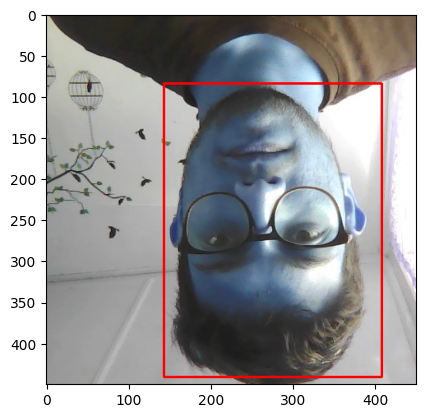

In [50]:
# draw the bounding box (bbox)
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augmented['image'])

# Build and Run Augmentation Pipeline

### Run Augmentation Pipeline

In [51]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type


### Load Augmented Images to Tensorflow Dataset

In [52]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [53]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [54]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [55]:
train_images.as_numpy_iterator().next()

array([[[0.13627452, 0.16715686, 0.16164216],
        [0.13480392, 0.17107843, 0.17696078],
        [0.13333334, 0.16715686, 0.18382353],
        ...,
        [0.6349878 , 0.6349878 , 0.6349878 ],
        [0.63284314, 0.63284314, 0.63284314],
        [0.64166665, 0.64166665, 0.64166665]],

       [[0.14656863, 0.1622549 , 0.1740196 ],
        [0.14552696, 0.1608456 , 0.17346814],
        [0.14166667, 0.16127451, 0.17346814],
        ...,
        [0.6357843 , 0.6357843 , 0.6357843 ],
        [0.6422181 , 0.6422181 , 0.6422181 ],
        [0.6433211 , 0.6433211 , 0.6433211 ]],

       [[0.1377451 , 0.15735294, 0.16911764],
        [0.13339461, 0.16476716, 0.1726103 ],
        [0.13431373, 0.16960785, 0.16568628],
        ...,
        [0.6387255 , 0.6387255 , 0.6387255 ],
        [0.6422181 , 0.6422181 , 0.6422181 ],
        [0.6431373 , 0.6431373 , 0.6431373 ]],

       ...,

       [[0.654902  , 0.654902  , 0.654902  ],
        [0.65882355, 0.65882355, 0.65882355],
        [0.65882355, 0

# Prepare Labels

### Build Label Loading Function

In [56]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = 'utf-8') as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### Load Labels to Tensorflow Dataset

In [57]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [58]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [59]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [60]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.0334, 0.2218, 0.624 , 1.    ], dtype=float16))

# Combine Label and Image Samples

### Check Partition Lengths

In [61]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

### Create Final Datasets (Images/Labels)

In [62]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [63]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [64]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [65]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.1931, 0.3613, 0.6377, 0.8037],
        [0.2112, 0.1439, 0.59  , 0.658 ],
        [0.593 , 0.4136, 0.8604, 0.7266],
        [0.    , 0.1359, 0.3147, 0.5166],
        [0.    , 0.1462, 0.4875, 0.7964],
        [0.    , 0.    , 0.    , 0.    ],
        [0.0827, 0.1162, 0.4695, 0.505 ],
        [0.3606, 0.421 , 0.7124, 0.8384]], dtype=float16))

### View Images and Annotations

In [66]:
data_samples = train.as_numpy_iterator()

In [89]:
res = data_samples.next()

In [90]:
res[1][1][0]

array([0.605 , 0.1311, 0.907 , 0.518 ], dtype=float16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


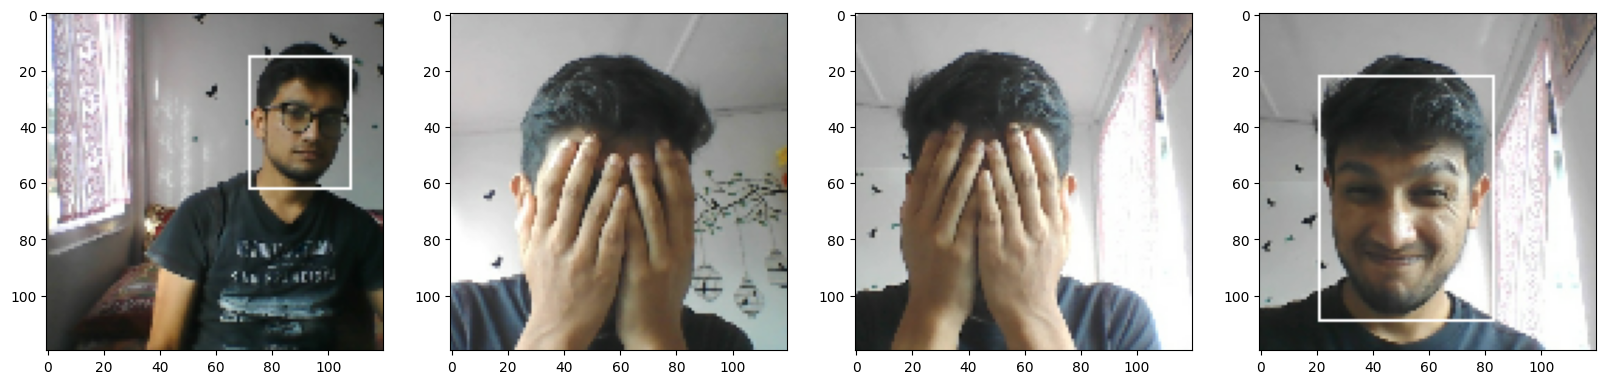

In [91]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))

for index in range(4):
    sample_image = res[0][index]
    sample_coords = res[1][1][index]
    
    cv2.rectangle(sample_image,
              tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
              tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
              (163, 10, 15), 1)

    ax[index].imshow(sample_image)

# Build Deep Learning using the Functional API

#### Import Layers and Base Network

In [92]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### Download VGG16

In [93]:
vgg = VGG16(include_top=False)

In [94]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Build instance of Network

In [95]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    # Classification Model -> check presence of face
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding Box Model -> get coordinates
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    face_tracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return face_tracker

### Test out Neural Network

In [96]:
face_tracker = build_model()

In [97]:
face_tracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [98]:
X, y = train.as_numpy_iterator().next()

In [99]:
classes, coords = face_tracker.predict(X)

1/1 [==============================] - 15s 15s/step


In [100]:
classes, coords

(array([[0.3030298 ],
        [0.3350263 ],
        [0.36933476],
        [0.35425267],
        [0.3458188 ],
        [0.31135488],
        [0.33501992],
        [0.340622  ]], dtype=float32),
 array([[0.5542164 , 0.6784753 , 0.6720701 , 0.6366137 ],
        [0.5597548 , 0.6336694 , 0.7228588 , 0.65824777],
        [0.5230132 , 0.63982296, 0.6876518 , 0.72062016],
        [0.532273  , 0.6275732 , 0.7243883 , 0.70434517],
        [0.4585268 , 0.6640371 , 0.79719275, 0.7229573 ],
        [0.6092432 , 0.6755041 , 0.7437662 , 0.6526855 ],
        [0.4774331 , 0.49688974, 0.80087656, 0.6865926 ],
        [0.45087108, 0.55751926, 0.7096285 , 0.7241114 ]], dtype=float32))

# Define Losses and Optimizers

### Define Optimizer and LR

In [101]:
batches_per_epoch = len(train)
lr_decay = (1.0 / 0.75 - 1) / batches_per_epoch

In [102]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### Create Localization Loss and Classification Loss

In [103]:
def localization_loss(y_true, y_hat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - y_hat[:, :2]))
    
    # actual height & width of the box
    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]
    
    # predicted height & width of the box
    h_pred = y_hat[:, 3] - y_hat[:, 1]
    w_pred = y_hat[:, 2] - y_hat[:, 0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [104]:
class_loss = tf.keras.losses.BinaryCrossentropy()
regress_loss = localization_loss

### Test out Loss Metrics

In [105]:
localization_loss(y[1], coords).numpy()

3.966084

In [106]:
class_loss(y[0], classes).numpy()

1.0900593

In [107]:
regress_loss(y[1], coords).numpy()

3.966084

# Train Neural Network

### Create Custom Model Class

In [108]:
class FaceTracker(Model):
    def __init__(self, eye_tracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eye_tracker
        
    def compile(self, opt, class_loss, localization_loss, **kwargs):
        super().compile(**kwargs)
        self.c_loss = class_loss
        self.l_loss = localization_loss
        self.opt = opt
        
    def train_step(self, batch, **kwargs):
        
        X, y = batch
        
        with tf.GradientTape() as tape:
            # predict
            classes, coords = self.model(X, training=True)
            
            # find loss
            batch_class_loss = self.c_loss(y[0], classes)
            batch_localization_loss = self.l_loss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localization_loss + 0.5 * batch_class_loss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": batch_class_loss, "regress_loss": batch_localization_loss}
    
    def test_step(self, batch, **kwargs):
        
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_class_loss = self.c_loss(y[0], classes)
        batch_localization_loss = self.l_loss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localization_loss + 0.5 * batch_class_loss
        
        return {"total_loss": total_loss, "class_loss": batch_class_loss, "regress_loss": batch_localization_loss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [109]:
model = FaceTracker(face_tracker)

In [110]:
model.compile(opt, class_loss, regress_loss)

### Train

In [111]:
log_dir = 'logs'

In [112]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [113]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
473/473 [==============================] - 58s 90ms/step - total_loss: 0.3232 - class_loss: 0.0707 - regress_loss: 0.2878 - val_total_loss: 0.7930 - val_class_loss: 0.5621 - val_regress_loss: 0.5120
Epoch 2/40
473/473 [==============================] - 44s 77ms/step - total_loss: 0.0446 - class_loss: 0.0066 - regress_loss: 0.0413 - val_total_loss: 0.0545 - val_class_loss: 0.0131 - val_regress_loss: 0.0479
Epoch 3/40
473/473 [==============================] - 42s 76ms/step - total_loss: 0.0356 - class_loss: 0.0046 - regress_loss: 0.0333 - val_total_loss: 0.0058 - val_class_loss: 1.7405e-05 - val_regress_loss: 0.0058
Epoch 4/40
473/473 [==============================] - 42s 77ms/step - total_loss: 0.0205 - class_loss: 0.0017 - regress_loss: 0.0196 - val_total_loss: 0.0040 - val_class_loss: 2.8075e-05 - val_regress_loss: 0.0040
Epoch 5/40
473/473 [==============================] - 42s 76ms/step - total_loss: 0.0076 - class_loss: 9.7752e-05 - regress_loss: 0.0075 - val_total_los

### Plot Performance

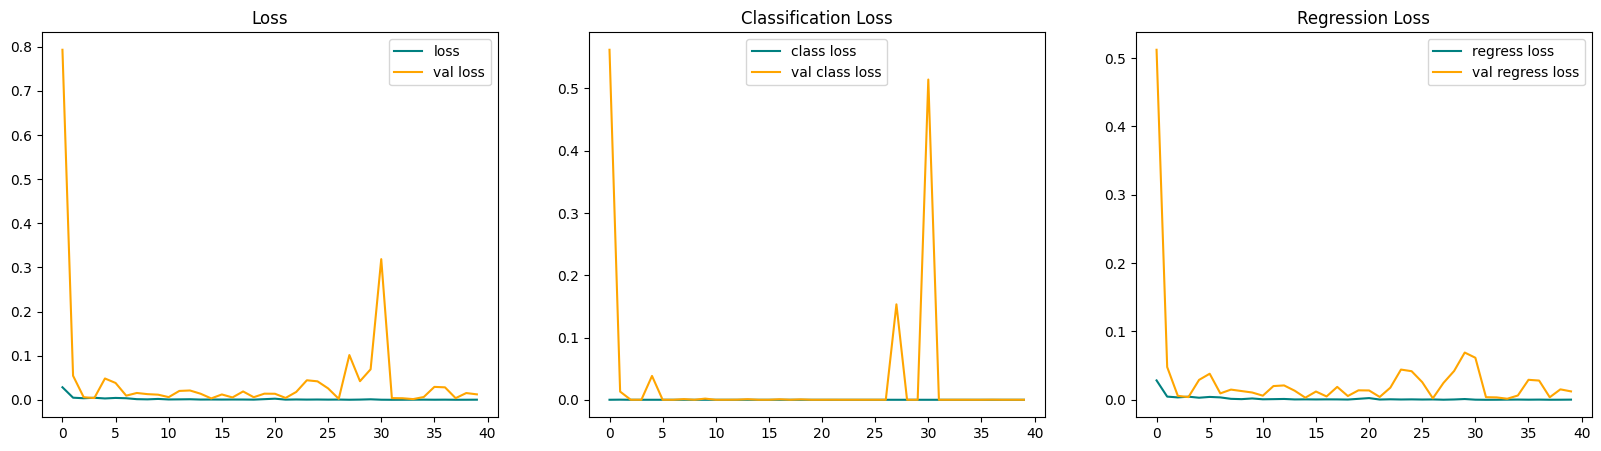

In [114]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Make Predictions

### Make Predictions on Test sets

In [115]:
test_data = test.as_numpy_iterator()

In [159]:
test_sample = test_data.next()

In [160]:
yhat = face_tracker.predict(test_sample[0])

1/1 [==============================] - 0s 27ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


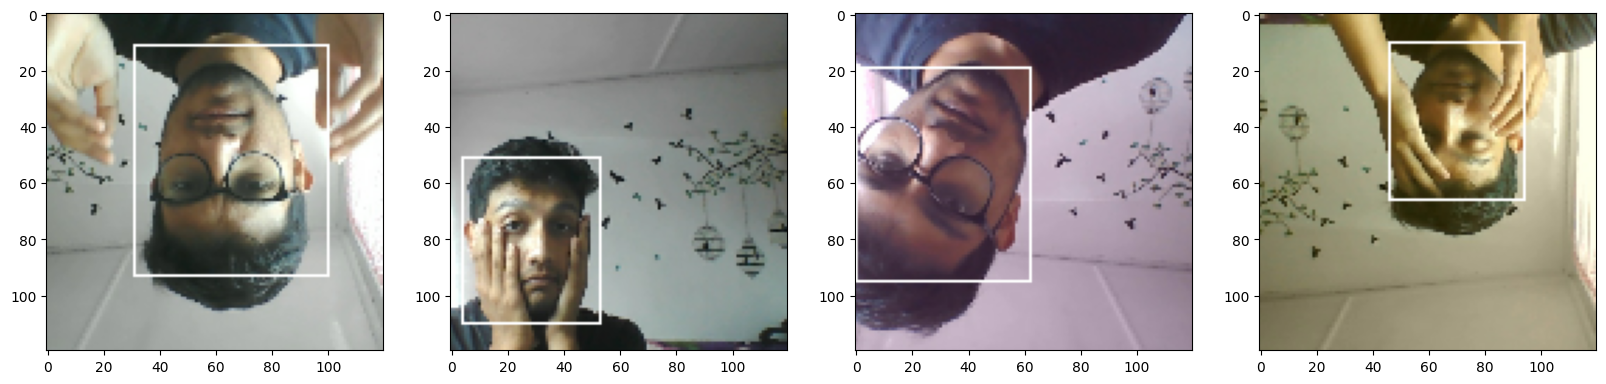

In [161]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for index in range(4): 
    sample_image = test_sample[0][index]
    sample_coords = yhat[1][index]
    
    if yhat[0][index] > 0.5:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (163, 10, 15), 1)
    
    ax[index].imshow(sample_image)

### Save the Model

In [162]:
from tensorflow.keras.models import load_model

In [163]:
face_tracker.save('facetracker.h5')

In [164]:
face_tracker = load_model('facetracker.h5')

## Real Time Detection

In [167]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500, :]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))
    
    yhat = face_tracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)), 
                            (255, 255, 255), 1)


        # If labelling of frame required
        '''
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), 
                                    [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                    [80, 0])), 
                            (255, 255, 255), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                               [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (163, 10, 15), 2, cv2.LINE_AA)
        '''
    
    cv2.imshow('Face Tracker', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 15ms/step
